# Bag of Visual Words implementation for Dog and Cat detection

## Library import

In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [2]:
print(os.getcwd())

/mnt/c/Users/Federico Arenas/Documents/Federico/UoE/MSC_AI/2021-1/IVC/Coursework/IVC_project


## Helper functions

## Convert dataframe to dictionary of images

In [8]:
# Get dataset of data split
def get_splits(split_n):
    '''

    '''
    path = './data/split_'+str(split_n)+'/split_'+str(split_n)+"_"
    train_df = pd.read_csv(path+'train.csv')
    val_df = pd.read_csv(path+'val.csv')

    return train_df, val_df

In [9]:
print('Convert dataframe to dictionary of images')
split_n = 2
train_splits, val_splits = get_splits(split_n)

Convert dataframe to dictionary of images


## Get split of data

In [10]:
# Read and store images
def image_reader(dataframe):
    '''
    '''
    image_dict = {}
    file_locations = list(dataframe['image_id'])
    labels = list(dataframe['label'])
    category_0 = []
    category_1 = []
    for i in tqdm(range(len(file_locations))):
        image = cv2.imread(file_locations[i]) #, cv2.COLOR_RGB2BGR)
        '''
        try:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        except: # if the image is gray
            print("grey image")
            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        '''
        if labels[i] == 0:
            category_0.append(image)
        else:
            category_1.append(image)

    image_dict[0] = category_0
    image_dict[1] = category_1

    return image_dict

In [11]:
# Get split 1 data
print('Get split 1 data')
train_dict = image_reader(train_splits)
val_dict = image_reader(val_splits)

Get split 1 data


  0%|          | 0/1191 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

In [14]:
len(val_dict[0])

204

In [15]:
len(val_dict[1])

203

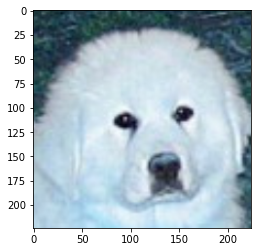

In [133]:
plt.imshow(train_dict[0][0])

## Get full sift features for training data

In [16]:
# Get SIFT features and descriptors
def sift_features(images):
    '''
    Creates descriptors using sift. Takes one parameter that is images dictionary. Return an array whose first 
    index holds the decriptor_list without an order and the second index holds the sift_vectors dictionary which
    holds the descriptors but this is seperated class by class.
    '''
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in tqdm(images.items()):
        features = []
        for img in tqdm(value):
            kp, des = sift.detectAndCompute(img,None)
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features

    return [descriptor_list, sift_vectors]

def dense_sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in tqdm(value):
            step = 10
            kps = []
            for i in range(step, len(img), step):
                for j in range(step, len(img[0]), step):
                    kps.append(cv2.KeyPoint(j, i, step))
            kp, des = sift.compute(img, kps, None)


            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return descriptor_list, sift_vectors

In [17]:
print('Get full sift features for training data')
train_descriptor_list = sift_features(train_dict)[0]
train_sift_vectors = sift_features(train_dict)[1]
print('Get full sift features for validation data...')
val_descriptor_list = sift_features(val_dict)[0]
val_sift_vectors = sift_features(val_dict)[1]
#np.save('output/bovw/sift_vectors.npy', sift_vectors)

Get full sift features for training data


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/591 [00:00<?, ?it/s]

Get full sift features for validation data...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

## Perform kmeans training to get visual words

In [25]:
# Perform kmeans clustering on descriptors
def kmeans(k, descriptor_list):
    '''
    A k-means clustering algorithm who takes 2 parameter which is number 
    of cluster(k) and the other is descriptors list(unordered 1d array)
    Returns an array that holds central points.
    '''
    kmeans = KMeans(n_clusters = k, n_init=3, verbose=0)
    kmeans.fit(descriptor_list)
    vwords = kmeans.cluster_centers_

    return kmeans, vwords

In [26]:
# Perform kmeans training to get visual words
K = 200
print('Perform clustering on training data...')
train_k_means, train_centers = kmeans(K, train_descriptor_list)
print('Perform clustering on validation data...')
val_k_means, valid_centers = kmeans(K, val_descriptor_list)

Perform clustering on training data...
Perform clustering on validation data...


## Get histograms from kmeans clustering

In [27]:
# Find index helper function
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
        else:
            dist = distance.euclidean(image, center[i]) 
            if(dist < count):
                ind = i
                count = dist
    return ind

# Extract visual words from descriptors  
def get_histograms_dictio(sift_vectors, kmeans_centers):
    '''
    '''    
    dict_feature = {}
    for key,value in sift_vectors.items():
        print(f"Getting histograms of class {key}...")
        category = []
        for img in tqdm(value):
            histogram = np.zeros(len(kmeans_centers))
            for each_feature in img:
                ind = find_index(each_feature, kmeans_centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# Map dictionary of histograms to np arrays
def get_histogram_arrays(sift_vectors, kmeans_centers):
    histogram_dictio = get_histograms_dictio(sift_vectors, kmeans_centers)
    X = []
    Y = []
    print("Converting to np.arrays...")
    for key in histogram_dictio.keys():
        for value in tqdm(histogram_dictio[key]):
            X.append(value)
            Y.append(key)
    
    return np.array(X), np.array(Y)

def get_histogram_arrays_2(sift_vectors, kmeans_centers):
    histogram_dictio = get_histograms_dictio(sift_vectors, kmeans_centers)
    X = []
    Y = []

    for val in histogram_dictio[0]:
        X.append(val)
        Y.append(0)

    for val in histogram_dictio[1]:
        X.append(val)
        Y.append(1)

    return np.array(X), np.array(Y)


In [28]:
print("Get histograms from kmeans clustering")
train_histograms, train_classes = get_histogram_arrays_2(train_sift_vectors, train_centers)
np.save('output/bovw/train_visual_words.npy', train_histograms)
np.save('output/bovw/train_classes.npy', train_classes)
print("Get validation histograms from kmeans clustering")
val_histograms, val_classes = get_histogram_arrays_2(val_sift_vectors, valid_centers)
np.save('output/bovw/val_visual_words.npy', val_histograms)
np.save('output/bovw/val_classes.npy', val_classes)

Get histograms from kmeans clustering
Getting histograms of class 0...


  0%|          | 0/600 [00:00<?, ?it/s]

Getting histograms of class 1...


  0%|          | 0/591 [00:00<?, ?it/s]

Get validation histograms from kmeans clustering
Getting histograms of class 0...


  0%|          | 0/204 [00:00<?, ?it/s]

Getting histograms of class 1...


  0%|          | 0/203 [00:00<?, ?it/s]

## Load data

In [29]:
loaded_train_histograms = np.load('output/bovw/train_visual_words.npy')
loaded_train_classes = np.load('output/bovw/train_classes.npy')
loaded_val_histograms = np.load('output/bovw/val_visual_words.npy')
loaded_val_classes = np.load('output/bovw/val_classes.npy')

## Prepare SVM Classifier

In [30]:
# Initialize SVM classifier
def train_svm(visual_words, labels, c, k_):
    # Get training data
    X_train = visual_words
    Y_train = labels

    # Initialize SVM classifier
    svc_classifier = make_pipeline(StandardScaler(), SVC(C=c, kernel=k_, gamma='auto'))
    svc_classifier.fit(X_train, Y_train)
    
    return svc_classifier

In [31]:
# Train SVM classifier
print("Train SVM classifier")
c_values = [2]
kernels = ['poly', 'rbf']
for c in c_values:
    for kernel in kernels:
        svm_classifier = train_svm(loaded_train_histograms, loaded_train_classes, c, kernel)
        print("---\tC: {};\tKernel: {}\t---".format(c, kernel))
        print("\tTraining accuracy:\t", svm_classifier.score(loaded_train_histograms, loaded_train_classes))
        print("\tValidation accuracy:\t", svm_classifier.score(loaded_val_histograms, loaded_val_classes))

Train SVM classifier
---	C: 2;	Kernel: poly	---
	Training accuracy:	 0.9538203190596137
	Validation accuracy:	 0.47665847665847666
---	C: 2;	Kernel: rbf	---
	Training accuracy:	 0.9605373635600336
	Validation accuracy:	 0.4864864864864865
